In [180]:
import re
import pandas
import glob
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [181]:
def get_model_name(path):
    return re.sub('.csv', '', re.sub("^.*/", '', path))

In [182]:
columns = ["timestamp", "seed", "env", "levelid", "move_limit", "click_limit", "objectives", "moves_performed",
           "clicks_performed", "objectives_achieved", "reward"]
eval_files = glob.glob("logs/eval/*.csv")
eval_data = [{'name': get_model_name(f), 'dataframe': pandas.read_csv(f, header=0, names=columns, index_col=False)} for
             f in eval_files]

## Completion Rate

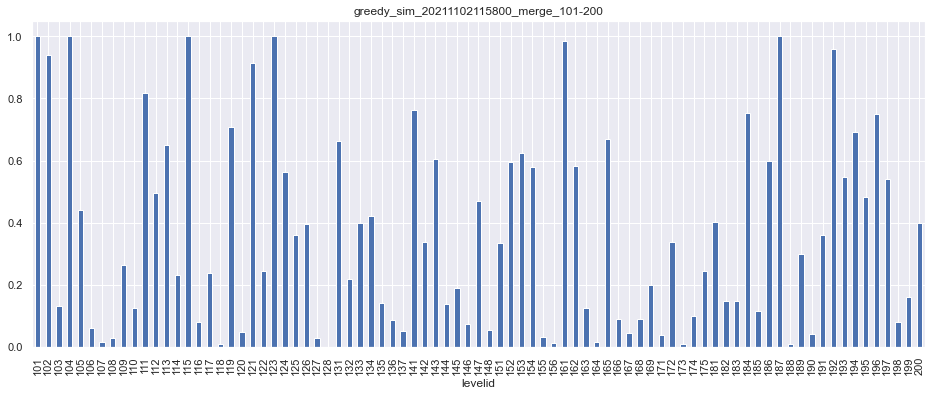

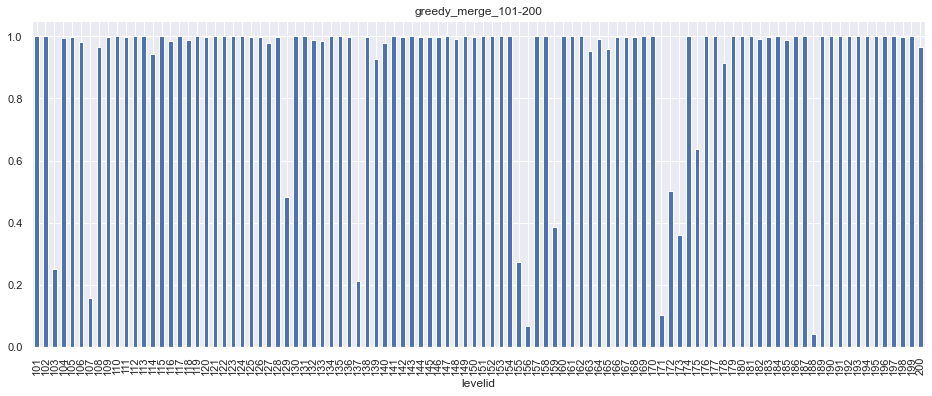

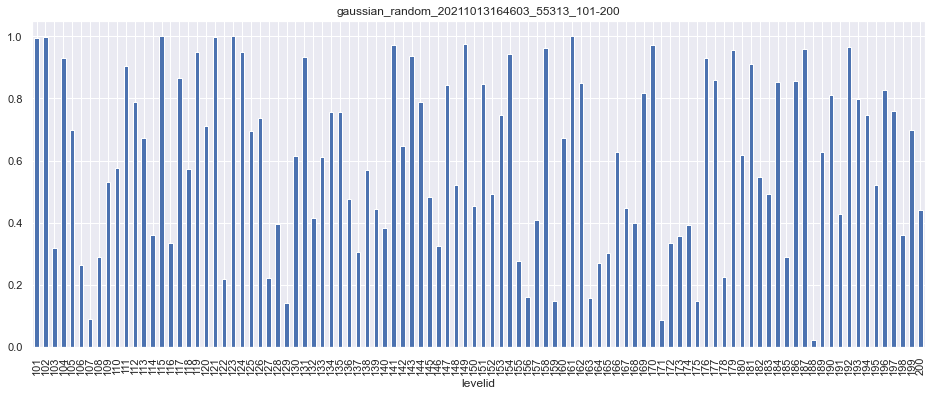

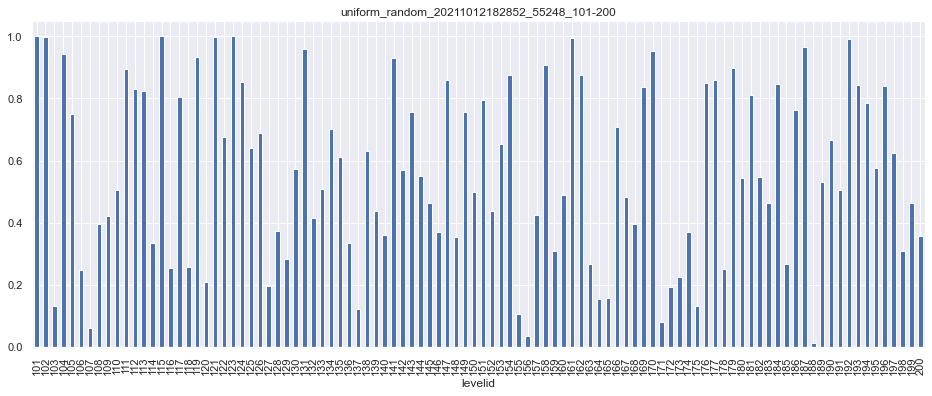

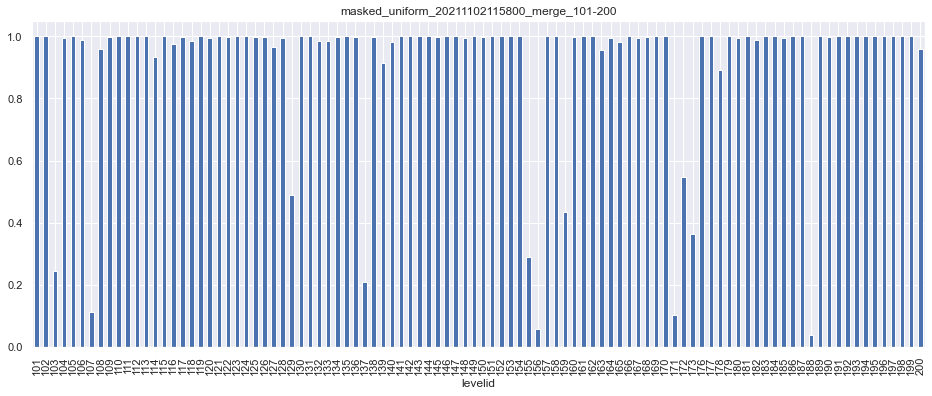

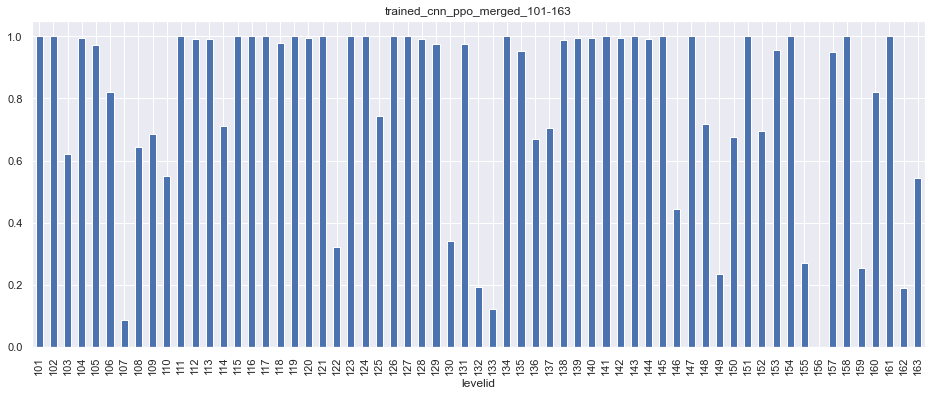

In [183]:
for ev in eval_data:
    ev['dataframe']['completed'] = ev['dataframe']['objectives'] == ev['dataframe']['objectives_achieved']
    pass_rate = ev['dataframe'].groupby('levelid').aggregate('mean')['completed']
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    pass_rate.plot.bar()

## Mean moves to complete a level

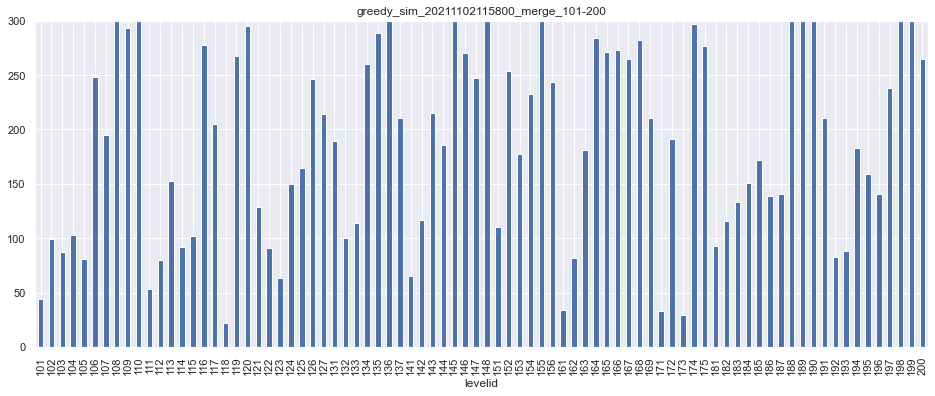

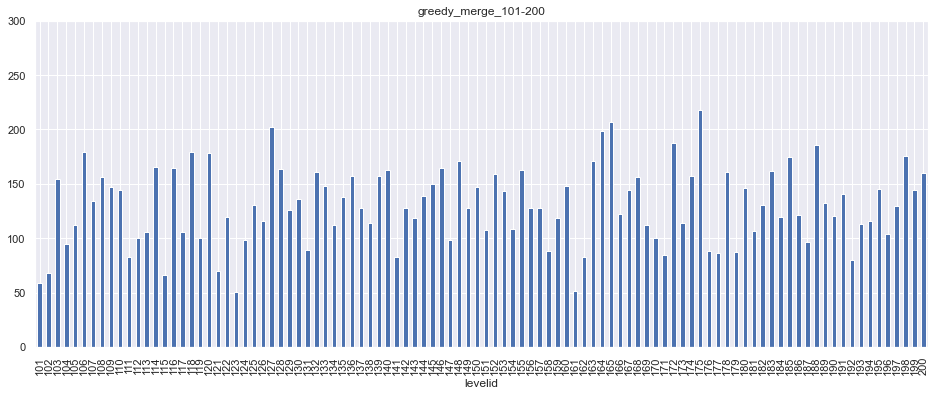

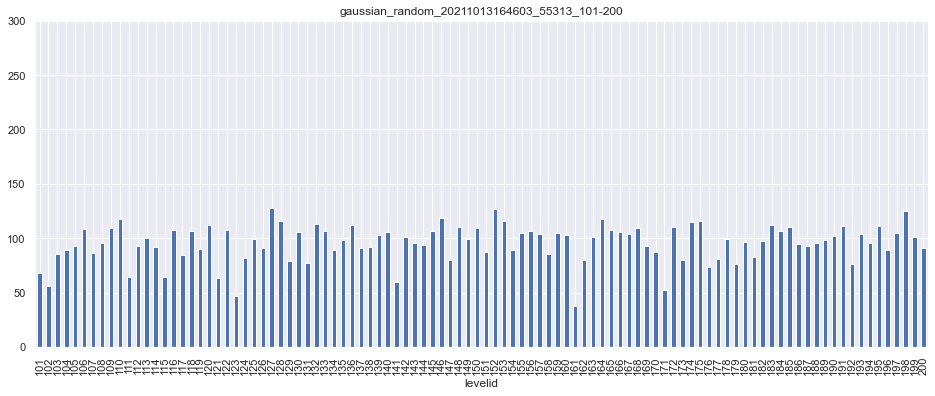

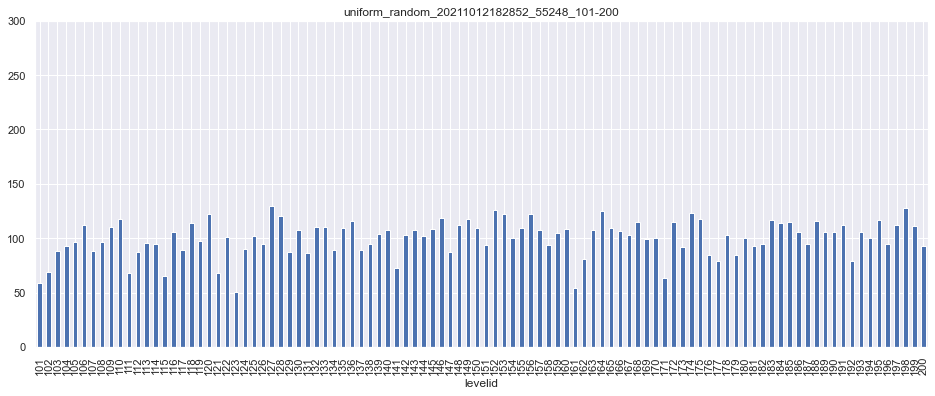

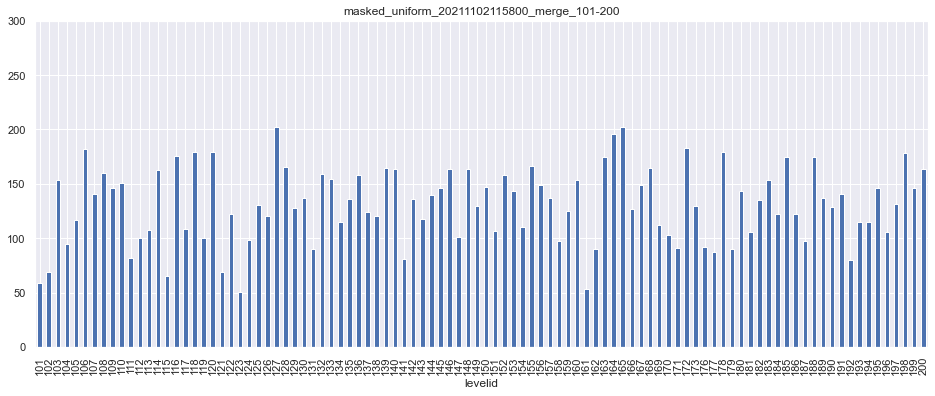

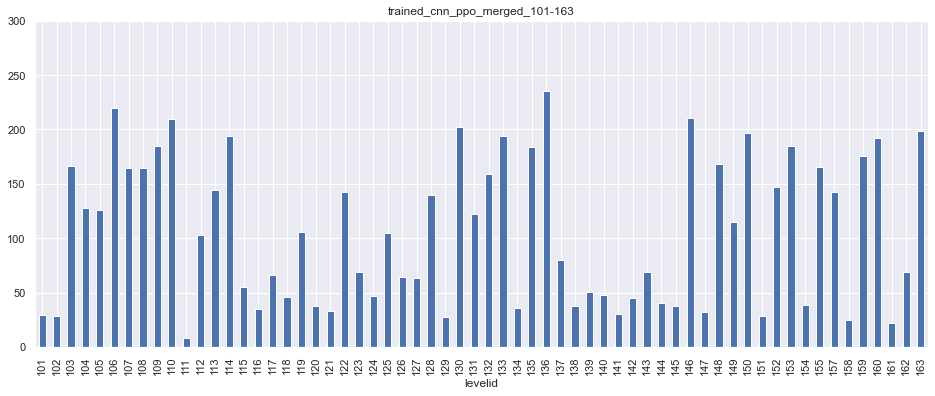

In [184]:
for ev in eval_data:
    completed_runs = ev['dataframe'][ev['dataframe'].completed == True]
    completed_runs_stats = completed_runs.groupby("levelid").aggregate('mean')
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    plt.ylim((0, 300))
    completed_runs_stats['moves_performed'].plot.bar()

## Moves distribution for level 122

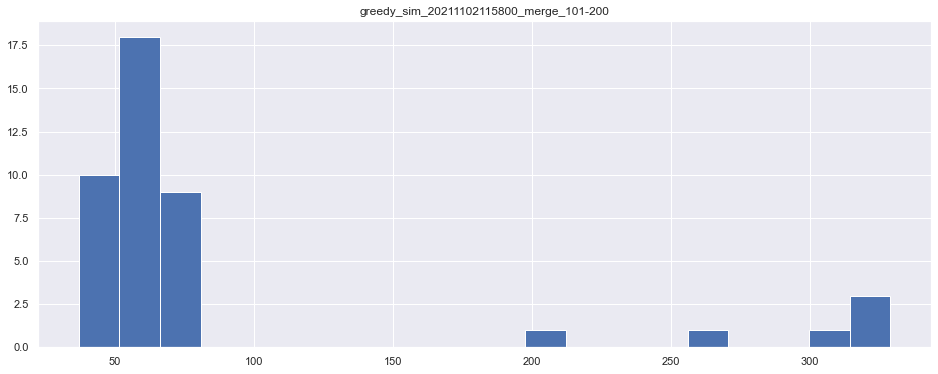

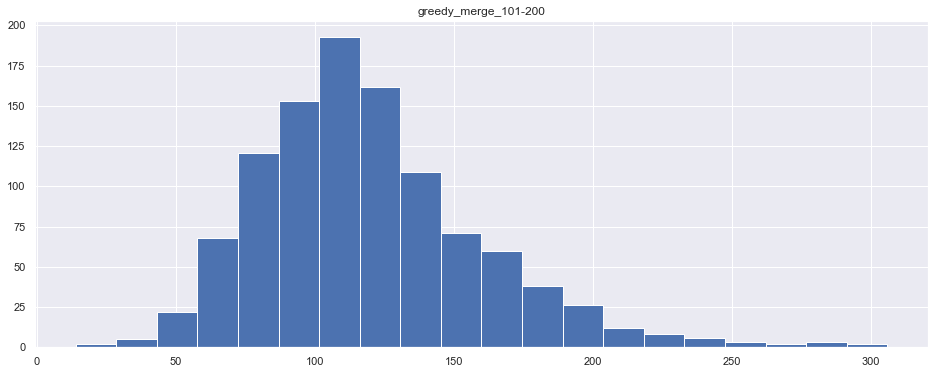

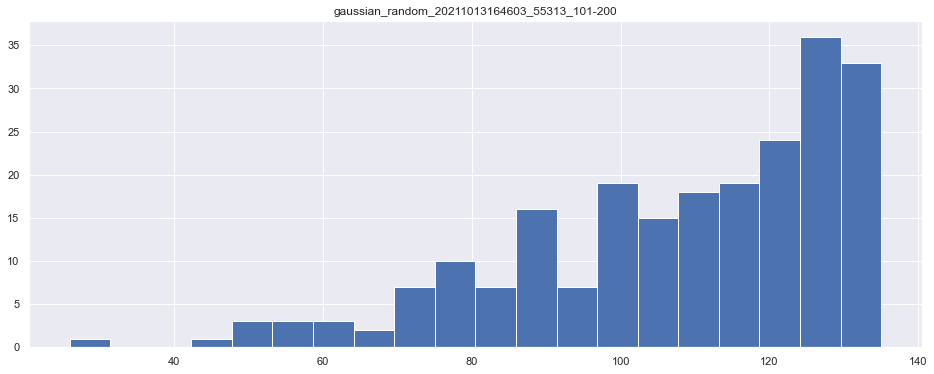

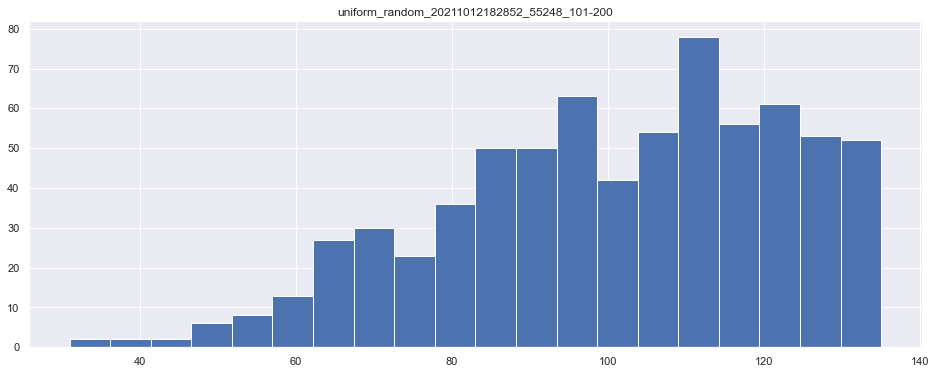

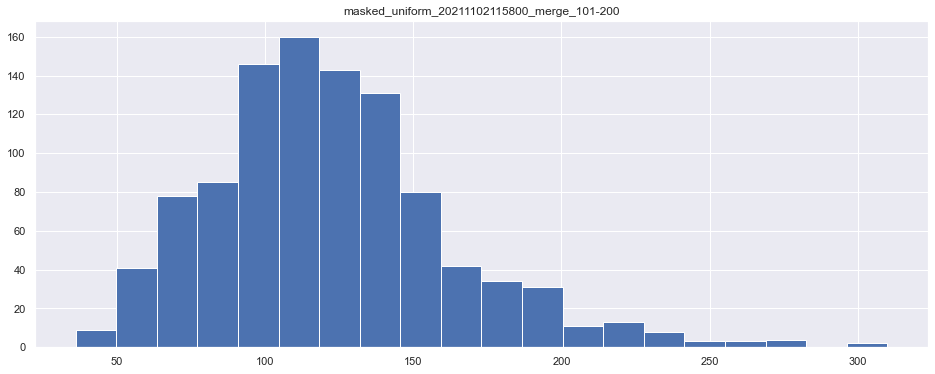

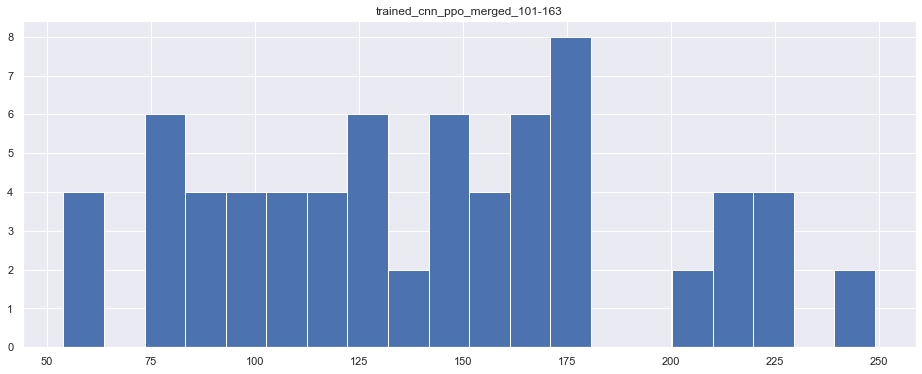

In [185]:
for ev in eval_data:
    completed_runs = ev['dataframe'][ev['dataframe'].completed == True]
    completed_runs_level = completed_runs[completed_runs['levelid'] == 122]
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])
    # completed_runs_level['clicks_performed'].hist(bins=20)
    completed_runs_level['moves_performed'].hist(bins=20)

## Moves distribution for level 155

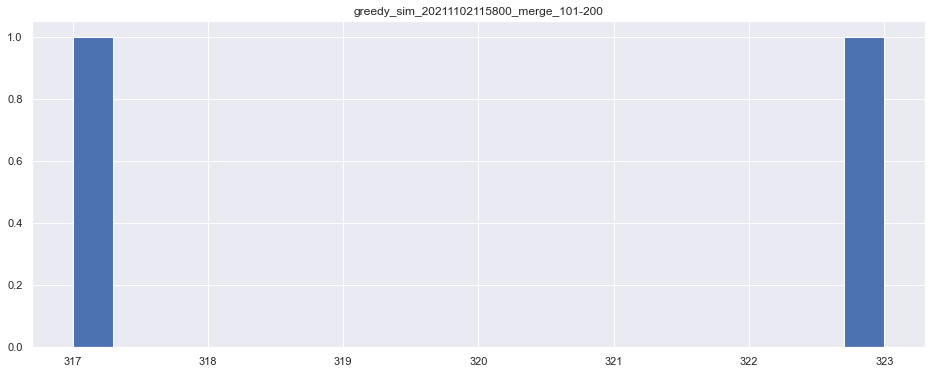

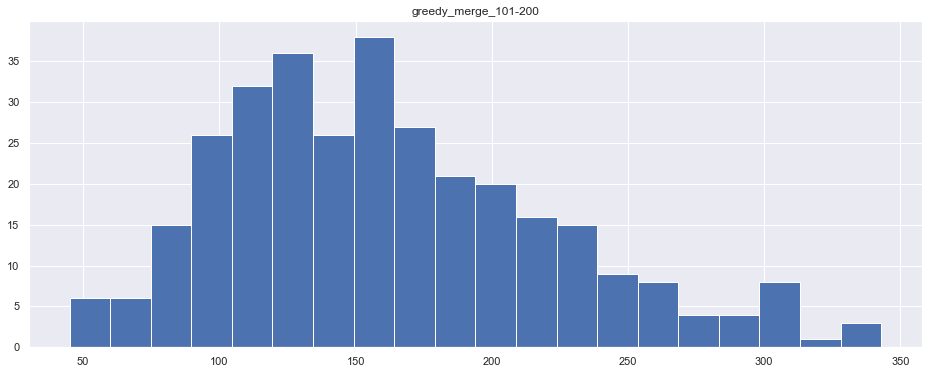

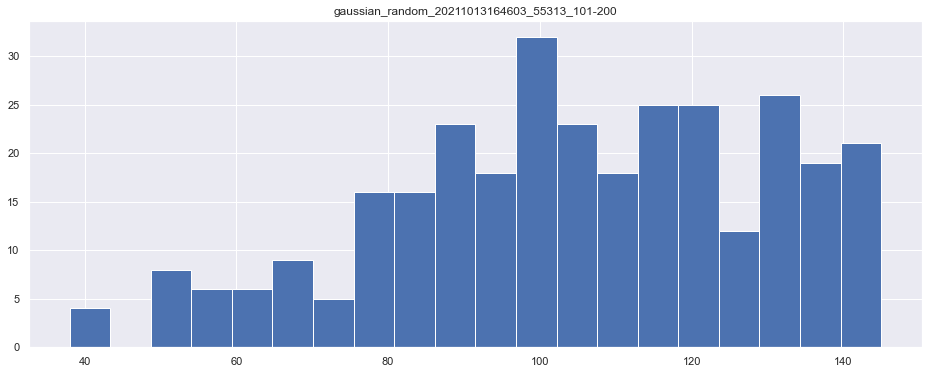

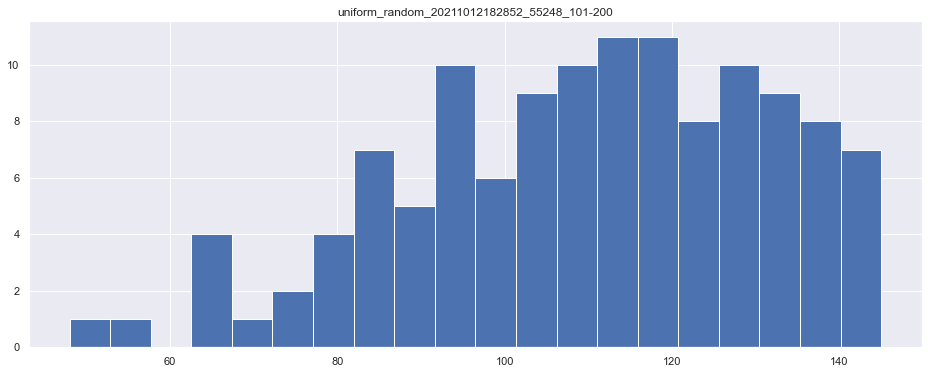

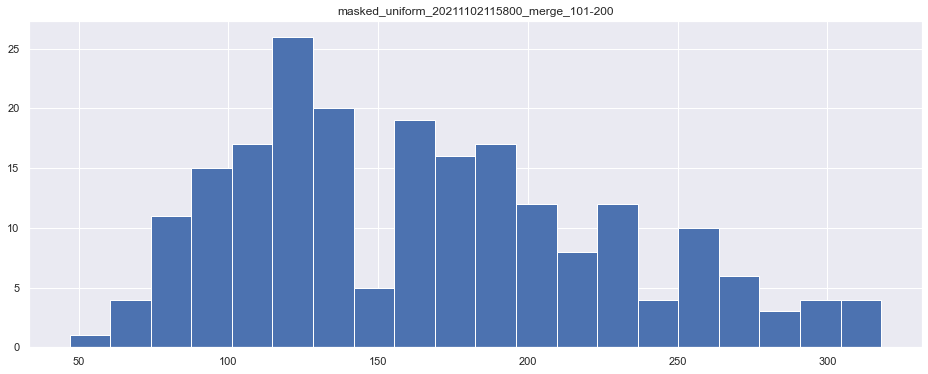

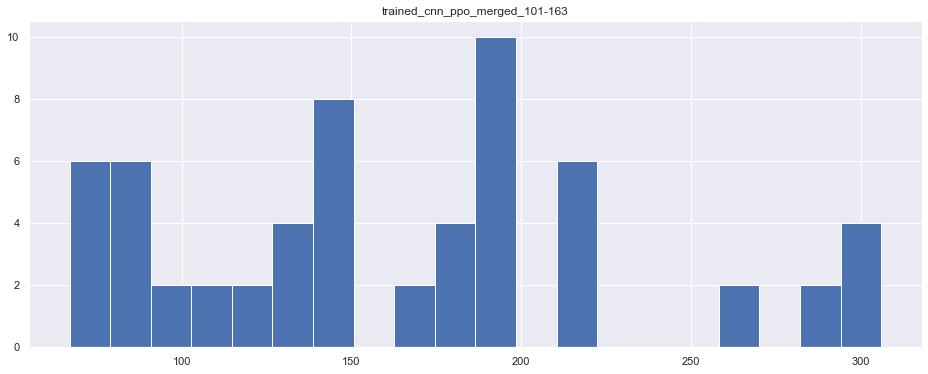

In [187]:
for ev in eval_data:
    completed_runs = ev['dataframe'][ev['dataframe'].completed == True]
    completed_runs_level = completed_runs[completed_runs['levelid'] == 155]
    plt.figure(figsize=(16, 6))
    plt.title(ev['name'])   
    # completed_runs_level['clicks_performed'].hist(bins=20)
    completed_runs_level['moves_performed'].hist(bins=20)